In [1]:
from Architectures.GAN import GAN
from Data.load import load
from matplotlib import pyplot as plt
import numpy as np

In [2]:
train, test = load("Pre-processed", take=5)

Loading images: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


In [3]:
gan_model = GAN(train.shape)

C:\Users\PieHu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Interpreted image shape: (80, 96, 80, 1)


Model: "GAN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 80, 96, 80, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator (Functional)          │ (None, 80, 96, 80, 1)  │       154,705 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator (Functional)      │ (None, 2, 2, 2, 1)     │   178,861,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,016,210 (682.89 MB)

 Trainable params: 154,473 (603.41 KB)

 Non-trainable params: 178,861,737 (682.30 MB)

In [4]:
gan_model.train(train[:1], epochs=100, batch_size=10)

ValueError: Dimensions must be equal, but are 10 and 2 for '{{node compile_loss/mean_squared_error/sub}} = Sub[T=DT_FLOAT](data_1, discriminator_1/conv3d_11_1/add)' with input shapes: [10,1], [1,2,2,2,1].

In [6]:
import numpy as np
np.random.uniform(10)

3.668631729686461

In [ ]:
latent_space = gan_model.encode(test)
decoded_image = gan_model.decode(latent_space)

print("Original image shape:", test.shape)
print("Latent space shape:", latent_space.shape)
print("Decoded image shape:", decoded_image.shape)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - loss: 0.1142 - val_loss: 0.1140
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 0.1119 - val_loss: 0.1140
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


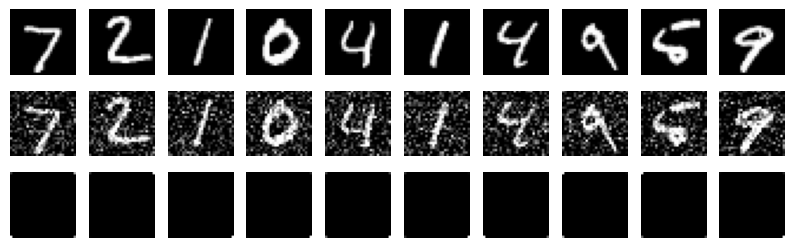

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

def build_unet():
    inputs = keras.Input(shape=(28, 28, 1))
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    return keras.Model(inputs, outputs)

def add_noise(images, noise_factor=0.3):
    noise = noise_factor * np.random.randn(*images.shape)
    return np.clip(images + noise, 0., 1.)

# Load MNIST dataset
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Add noise
x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

# Build model
model = build_unet()
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(x_train_noisy, x_train, epochs=3, batch_size=64, validation_data=(x_test_noisy, x_test))

# Generate denoised images
predicted = model.predict(x_test_noisy[:10])

# Plot results
fig, axes = plt.subplots(3, 10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(x_test[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(x_test_noisy[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[2, i].imshow(predicted[i].squeeze(), cmap='gray')
    axes[2, i].axis('off')
plt.show()


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

print("tf version: ", tf.__version__)

# data
diffusion_steps = 20
image_size = 28

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# optimization
batch_size = 64
num_epochs = 1000
learning_rate = 1e-3

embedding_dims = 32
embedding_max_frequency = 1000.0


x0 = tf.keras.Input(shape=(28, 28, 1))
t0 = tf.keras.Input(shape=(1, 1, 1))

combined = tf.keras.layers.Add()([x0, t0])

x = tf.keras.layers.Flatten()(combined)
x = tf.keras.layers.Dense(7 * 7 * 64, activation="relu")(x)
x = tf.keras.layers.Reshape((7, 7, 64))(x)
x = tf.keras.layers.Conv2DTranspose(
    64, 3, activation="relu", strides=2, padding="same"
)(x)
x = tf.keras.layers.Conv2DTranspose(
    32, 3, activation="relu", strides=2, padding="same"
)(x)
output = tf.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
network = tf.keras.Model(inputs=[x0, t0], outputs=output)
print(network.summary())


class DiffusionModel(tf.keras.Model):
    def __init__(self, network):
        super().__init__()

        self.normalizer = tf.keras.layers.Normalization()
        self.network = network

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker = tf.keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = tf.keras.metrics.Mean(name="i_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]

    def denormalize(self, images):
        return tf.clip_by_value(images, 0.0, 1.0)

    # predictive stage
    def denoise(self, noisy_images, times, training):
        # predict noise component and calculate the image component using it
        with tf.GradientTape() as tape:
            tape.watch(noisy_images)
            pred_noises = self.network([noisy_images, times**2], training=training)
            gradients = tape.gradient(pred_noises, noisy_images)
        pred_images = noisy_images - pred_noises - gradients
        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, steps):
        # reverse diffusion = sampling
        batch = initial_noise.shape[0]
        step_size = 1.0 / steps
        
        next_noisy_images = initial_noise
        next_diffusion_times = tf.ones((batch, 1, 1, 1))

        for step in range(diffusion_steps):
            noisy_images = next_noisy_images
            diffusion_times = next_diffusion_times

            pred_noises, pred_images = self.denoise(
                noisy_images, diffusion_times, training=False
            )

            # this new noisy image will be used in the next step
            next_diffusion_times = diffusion_times - step_size
            next_noisy_images = pred_images + pred_noises
        return pred_images

    def generate(self, num_images, steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 1))
        generated_images = self.reverse_diffusion(initial_noise, steps)
        return generated_images

    def train_step(self, images):
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 1))
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )

        with tf.GradientTape(persistent=True) as tape:
            noisy_images = images + noises
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, diffusion_times, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric
            
            # total_loss = noise_loss + image_loss

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)
        return {m.name: m.result() for m in self.metrics}

    def plot_images(
        self,
        epoch=None,
        logs=None,
        num_rows=3,
        num_cols=6,
        write_to_file=True,
        output_dir="output",
    ):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            steps=diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")

        plt.tight_layout()

        if write_to_file:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            if epoch is not None:
                filename = os.path.join(
                    output_dir, "image_epoch_{:04d}.png".format(epoch)
                )
            else:
                import time

                timestr = time.strftime("%Y%m%d-%H%M%S")
                filename = os.path.join(output_dir, "image_{}.png".format(timestr))
            plt.savefig(filename)
        else:
            plt.show()

        plt.close()


# create and compile the model
model = DiffusionModel(network)
model.compile(
    optimizer="adam",#tf.keras.optimizers.experimental.AdamW(learning_rate=learning_rate),
    loss=tf.keras.losses.MeanSquaredError,
    # loss="mse",
)
# pixelwise mean absolute error is used as loss

# save the best model based on the noise loss
# checkpoint_path = "checkpoints/diffusion_model"
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path,
#     save_weights_only=True,
#     monitor="n_loss",
#     mode="min",
#     save_best_only=True,
# )

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)
dataset = dataset.batch(batch_size, drop_remainder=True)
dataset = dataset.shuffle(10000, reshuffle_each_iteration=True)


# run training and plot generated images periodically
model.fit(
    dataset,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[
        tf.keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        # checkpoint_callback,
    ],
)

# load the best model and generate images
# model.load_weights(checkpoint_path)
model.plot_images(write_to_file=False)

tf version:  2.17.0


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1, 1, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 28, 28, 1) │          0 │ input_layer_2[0]… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 784)       │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3136)      │  2,461,760 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 7, 7, 64)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 14, 14,    │     36,928 │ reshape_1[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 28, 28,    │     18,464 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 28, 28, 1) │        289 │ conv2d_transpose… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,517,441 (9.60 MB)

 Trainable params: 2,517,441 (9.60 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000


OperatorNotAllowedInGraphError: Using a symbolic `tf.Tensor` as a Python `bool` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.